# Random Forest


Libraries and data.

In [20]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import HistGradientBoostingClassifier

# Data
# X_train_df = pd.read_csv('gold/X_train_df.csv', index_col='respondent_id') # training set features
h1n1_X_train_df = pd.read_csv('../data/gold/h1n1_X_train_df.csv', index_col='respondent_id') # training set features
seasonal_X_train_df = pd.read_csv('../data/gold/seasonal_X_train_df.csv', index_col='respondent_id') # training set features


training_set_labels_df = pd.read_csv('../data/raw/training_set_labels.csv', index_col='respondent_id') # training set labels

# X_test_df = pd.read_csv('gold/X_test_df.csv', index_col='respondent_id') # test set features
h1n1_X_test_df = pd.read_csv('../data/gold/h1n1_X_test_df.csv', index_col='respondent_id') # test set features
seasonal_X_test_df = pd.read_csv('../data/gold/seasonal_X_test_df.csv', index_col='respondent_id') # test set features

submission_format_df = pd.read_csv('../data/raw/submission_format.csv', index_col='respondent_id') # submission format

Data split for h1n1 and seasonal (each with its own variables).

In [21]:
h1n1_X_train, h1n1_X_test, h1n1_y_train, h1n1_y_test = train_test_split(h1n1_X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df)
seasonal_X_train, seasonal_X_test, seasonal_y_train, seasonal_y_test = train_test_split(seasonal_X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df)

Cross-validation.

In [22]:
# Set up the MultiOutputClassifier with Random Forest Regressor
multi_output_clf = MultiOutputClassifier(HistGradientBoostingClassifier(random_state=42))

In [23]:
# Let's do GridSearchCV
# parameters grid
param_grid = {
    "estimator__learning_rate" : [0.05, 0.1, 0.2, 0.3],
    "estimator__max_iter" : [100, 200, 300],
    "estimator__max_leaf_nodes" : [31, 63, 127],
    "estimator__max_depth" : [None, 5, 10, 20, 30],
    "estimator__min_samples_leaf" : [20, 50, 100],
}

In [24]:
# Initialize Grid Search
grid_search = GridSearchCV(estimator=multi_output_clf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

# Fit the Grid Search model
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters from Grid Search:", grid_search.best_params_)
print("Best Score from Grid Search:", grid_search.best_score_)

# Evaluate on the test set
y_pred_grid = grid_search.predict(X_test)
mse_grid = mean_squared_error(y_test, y_pred_grid)
acc_grid = accuracy_score(y_test, y_pred_grid)
print(f"Mean Squared Error (Grid Search): {mse_grid}")
print(f"Accuracy (Grid Search): {acc_grid}")

Best hyperparameters.

In [25]:
h1n1_estimators = MultiOutputClassifier(
    estimator=HistGradientBoostingClassifier()
)
seasonal_estimators = MultiOutputClassifier(
    estimator=HistGradientBoostingClassifier()
)

The models (one for each prediction) are trained to study performance.

In [26]:
h1n1_estimators.fit(h1n1_X_train, h1n1_y_train)

MultiOutputClassifier(estimator=GradientBoostingClassifier())

In [27]:
seasonal_estimators.fit(seasonal_X_train, seasonal_y_train)

MultiOutputClassifier(estimator=GradientBoostingClassifier())

Predictions.

In [28]:
h1n1_preds = h1n1_estimators.predict_proba(h1n1_X_test)
h1n1_preds_predict = h1n1_estimators.predict(h1n1_X_test)

In [29]:
seasonal_preds = seasonal_estimators.predict_proba(seasonal_X_test)
seasonal_preds_predict = seasonal_estimators.predict(seasonal_X_test)

A dataframe is created with the predictions.

In [30]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': h1n1_preds[0][:,1],
        'seasonal_vaccine':seasonal_preds[1][:,1],
    },
    index=seasonal_y_test.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (5342, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
22317,0.019706,0.433264
1215,0.733934,0.789557
10540,0.051128,0.087878
7407,0.131051,0.201041
14697,0.109470,0.307417


### **RESULTS: ROC CURVE**

ROC curve to evaluate models.

In [31]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], color='red', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

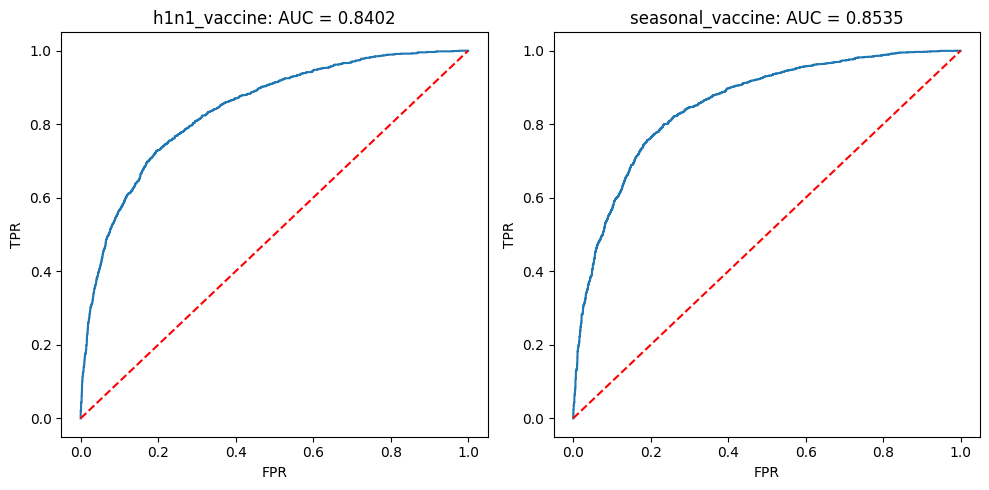

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

plot_roc(
    h1n1_y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0])

plot_roc(
    seasonal_y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1])

fig.tight_layout()

- AUC of 0.8641 for h1n1_vaccine: This indicates that the model has a good ability to distinguish between positive and negative classes. An AUC of 0.8641 is quite high, suggesting an effective model for predicting whether a person will receive the H1N1 vaccine.

- An AUC of 0.8502 indicates that the model performs well in predicting the seasonal vaccine, although it is a bit less accurate compared to the prediction for the H1N1 vaccine.

### **RESULTS: CONFUSION MATRIX**

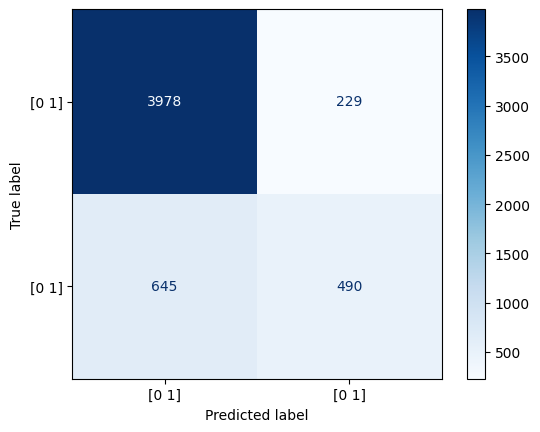

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      4207
           1       0.68      0.43      0.53      1135

    accuracy                           0.84      5342
   macro avg       0.77      0.69      0.71      5342
weighted avg       0.82      0.84      0.82      5342



In [33]:
# h1n1_vaccine
cm = metrics.confusion_matrix(h1n1_y_test['h1n1_vaccine'], h1n1_preds_predict[:, 0])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=h1n1_estimators.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print the classification report
print(metrics.classification_report(h1n1_y_test['h1n1_vaccine'], h1n1_preds_predict[:, 0]))

In summary, the model performs well overall, with a precision of 0.89 for class 0 and 0.68 for class 1, meaning it is more accurate at predicting class 0. The recall is higher for class 0 (0.93) than for class 1 (0.56) (the model detects class 0 instances better).

The overall accuracy is 0.85, and the F1-score is quite good, especially for class 0, suggesting a good balance between precision and recall. However, the model struggles to correctly identify class 1, as seen in its lower precision and recall for this class.

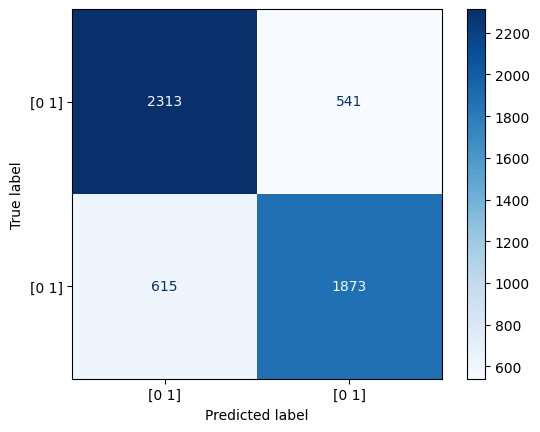

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2854
           1       0.78      0.75      0.76      2488

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



In [34]:
# seasonal_vaccine
cm = metrics.confusion_matrix(seasonal_y_test['seasonal_vaccine'], seasonal_preds_predict[:, 1])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=seasonal_estimators.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Print the classification report
print(metrics.classification_report(seasonal_y_test['seasonal_vaccine'], seasonal_preds_predict[:, 1]))

In summary, the model performs fairly well, with a precision of 0.79 for class 0 and 0.76 for class 1, meaning it is slightly more accurate at predicting class 0. The recall is also similar for both classes, with 0.79 for class 0 and 0.76 for class 1, showing that the model detects both classes fairly well.

The overall accuracy is 0.77, and the F1-score is the same for both classes (0.79 for class 0 and 0.76 for class 1), indicating a decent balance between precision and recall. The results are consistent across both classes, with the model performing similarly for both.

### **FIT AND PREDICT RESULTS FOR COMPETITION UPLOAD**

The models (one for each prediction) are trained for the competition.

In [35]:
h1n1_estimators.fit(h1n1_X_train_df, training_set_labels_df)
h1n1_preds = h1n1_estimators.predict_proba(h1n1_X_test_df)
h1n1_preds

[array([[0.89245785, 0.10754215],
        [0.94804828, 0.05195172],
        [0.54016694, 0.45983306],
        ...,
        [0.89301235, 0.10698765],
        [0.94830467, 0.05169533],
        [0.58945964, 0.41054036]]),
 array([[0.68177541, 0.31822459],
        [0.90333965, 0.09666035],
        [0.20157444, 0.79842556],
        ...,
        [0.85654753, 0.14345247],
        [0.61368331, 0.38631669],
        [0.54776803, 0.45223197]])]

In [36]:
seasonal_estimators.fit(seasonal_X_train_df, training_set_labels_df)
seasonal_preds = seasonal_estimators.predict_proba(seasonal_X_test_df)
seasonal_preds

[array([[0.88167652, 0.11832348],
        [0.94937676, 0.05062324],
        [0.63277495, 0.36722505],
        ...,
        [0.89215715, 0.10784285],
        [0.87380541, 0.12619459],
        [0.75102085, 0.24897915]]),
 array([[0.80641089, 0.19358911],
        [0.94304445, 0.05695555],
        [0.23435902, 0.76564098],
        ...,
        [0.81714639, 0.18285361],
        [0.62072143, 0.37927857],
        [0.35442808, 0.64557192]])]

A dataframe is created with the predictions.

In [37]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': h1n1_preds[0][:,1],
        'seasonal_vaccine':seasonal_preds[1][:,1],
    },
    index=h1n1_X_test_df.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (26708, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.107542,0.193589
26708,0.051952,0.056956
26709,0.459833,0.765641
26710,0.499108,0.865499
26711,0.236867,0.489586


Export the CSV.

In [38]:
y_preds.to_csv('../results/pred_random_forest_output.csv', index = True)